In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("../data/archive.hdf5", 'r')

In [2]:
# wl_min = 5101#5590
# wl_max = 5300#5610
wl_min = 5850
wl_max = 5940

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

In [4]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
#     plt.plot(sp.wavelength, sp.flux)
    
# plt.ylim([0, 3])

In [27]:
# Expensive, only run once:
dx = []
for i in range(1, len(spectra)):
    cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
                              spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
    dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())

np.save('dx.npy', dx)

# dx = np.load('data/dx.npy')

In [6]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [7]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [8]:
from json import load
f_S = load(open('../f_S.json'))

In [9]:
phoenix_wl, phoenix_fl = np.load('../data/chunk.npy')


In [10]:
from sklearn.linear_model import RANSACRegressor

In [11]:
r = RANSACRegressor()

In [28]:
coadded = spectra[0].flux

spectral_grid = None #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []
wl = spectra[0].wavelength
wl = wl[(wl > wl_min) & (wl < wl_max)]

# plt.figure(figsize=(14, 4))
for i in range(1, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 2:
        spectra_indices.append(i)
        date_key = str(dates[i-1].datetime.date())    
        all_fs.append(f_S[date_key])
        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(wl, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        phoenix_fl_interp = np.interp(wl, phoenix_wl - 0.5, phoenix_fl)
        X = np.vstack([rolled_spectrum, (wl - wl.mean())**2, wl - wl.mean()]).T
        c = np.linalg.lstsq(X, phoenix_fl_interp)[0]
        rolled_spectrum = X @ c

#         r.fit(X, phoenix_fl_interp)
#         c = r.estimator_.coef_
# #         print(c)
        rolled_spectrum = X @ c

#         fit = np.polyfit(spectra[0].wavelength-spectra[0].wavelength.mean(), rolled_spectrum, 1)
#         rolled_spectrum /= np.polyval(fit, spectra[0].wavelength-spectra[0].wavelength.mean())#np.median(rolled_spectrum)
#         plt.figure(figsize=(14, 4))
#         plt.plot(wl, rolled_spectrum)
#         plt.plot(wl, phoenix_fl_interp)
#         plt.show()
#         coadded += rolled_spectrum
        if spectral_grid is None: 
            spectral_grid = rolled_spectrum
        else:
            spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
# plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


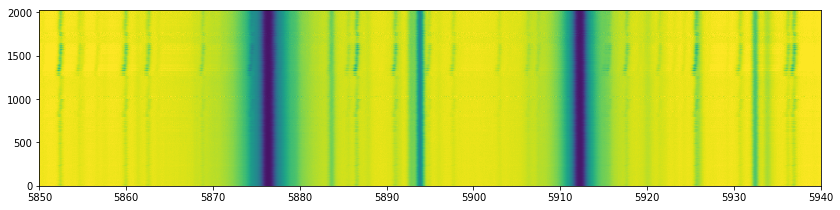

In [29]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1.01)
plt.gca().set_aspect(0.01)

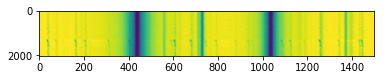

In [30]:
wl_max = 5900
wl_min = 5885


bounds = (wl < wl_max) & (wl > wl_min) # np.ones_like(wl).astype(bool) #
cutout = spectral_grid[:, bounds]

plt.imshow(cutout, vmin=0, vmax=1)
plt.gca().set_aspect(0.10)

In [31]:
all_fs = np.array(all_fs)

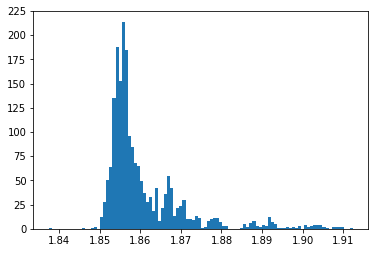

In [40]:
ew = np.trapz(1 - cutout, wl[bounds])

mask =  (ew < 1.95) # np.ones(len(ew)).astype(bool) 

plt.hist(ew[mask], 100);

In [41]:
from scipy.stats import spearmanr

In [42]:
spearmanr(all_fs[mask], ew[mask])

SpearmanrResult(correlation=-0.046895891704054, pvalue=0.03520473960388715)

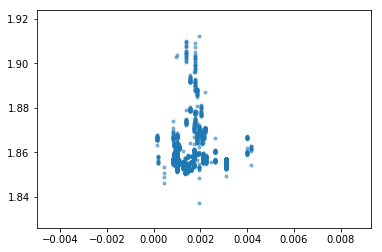

In [43]:
plt.scatter(all_fs[mask], ew[mask], alpha=0.5, marker='.')

In [48]:
(spectral_grid.T - np.median(spectral_grid, axis=1)).shape
wl[bounds].shape

(1499,)

In [46]:
np.save('data/regressed.npy', spectral_grid.T - np.median(spectral_grid, axis=1))
np.save('data/regressed_wl.npy', wl[bounds])

In [45]:
np.save('data/all_fs.npy', all_fs)

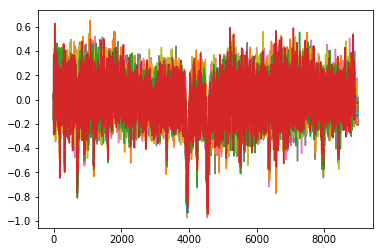

In [26]:
# plt.plot(spectral_grid.T - np.median(spectral_grid, axis=1));